# Hyperpolarized C13 EPSI Reconstruction Demo

This demonstration shows the reconstruction of a Hyperpolarized C13 echo-planar spectroscopic imaging (EPSI) reconstruction, specifically for data acquired with a compressed-sensing EPSI pulse sequence.  This sequence uses pseudo-random blip gradients during the EPSI readout to randomly cover k-space.  These random blips vary across dynamic time points as well.  Additional details about the sampling and reconstruction can be found in

https://doi.org/10.1002/mrm.22650

https://doi.org/10.1002/mrm.27179


## Install code, setup path

To run this code you will need to clone the hyperpolarized MRI toolbox
repository from github and add it to your matlab path. 
This can be done with the following command:
'git clone https://github.com/LarsonLab/hyperpolarized-mri-toolbox/'

This also requires the Optimization Toolbox (Matlab) or 'optim' toolbox (Octave) for the kinetic model fitting and Image Processing Toolbox ('image' in Octave) for plots


In [1]:
% setup hyperpolarized-mri-toolbox
root_dir = sprintf('%s/',pwd)

cd ../../
startup

root_dir = C:\Users\PLarson\Documents\GitHub\hyperpolarized-mri-toolbox\recon\EPSI demo/
loading optim
loading image


In [2]:
% Setup data structures
fb_root_name = 'csimage_in';
samp_pattern_name = 'loc_samp_3d_dyn';
numReps = 18;

The following code to fill in missing k-space data using a compressed sensing reconstruction was extracted from the following function call

> kspace_all = recon_cs3d_dyn_sivic_v1(root_dir, fb_root_name, samp_pattern_name, numReps);

In [3]:
% setup additional parameters (from recon_cs3d_dyn_sivic_v1)

Navg = 1;

% compressed sensing weights for 
Itnlim = 16;
loopIter = 6;
TVWeight = 1e-6;
xfmWeight = 1e-2;
wavelet_time_scale = 2;  % similar between 0,1,2

plot_test = 0;

timedim = 4; % after squeeze



In [4]:
% load and setup data structures

load([root_dir samp_pattern_name]); % File from blip generation

S = size(loc_samp_3d_dyn);
length_x = S(1); length_y = S(2); length_f = S(3);
length_z = 16;

% data_all = zeros(length_f, length_x, length_y, length_z, numReps);
mask_all = zeros(length_f, length_x, length_y, numReps);


for n = 1:numReps
    Isum = [1:Navg] + (n-1)*Navg;
    
    mask_all(:,:,:,n) = ...
        shiftdim(any(loc_samp_3d_dyn(:,:,:,Isum),4),2);
end

load([root_dir fb_root_name]); % File from 3d undersample dataset

N = size(mask_all); % k-space and image size do not have to be the same
NN1 = 2^ceil(log(N(1))/log(2));
if numReps > 1
    NN4 = 2^ceil(log(N(4))/log(2)); % interpolate to diadic number for wavelets
else
    NN4 = 1;
end
NN = [NN1,N(2),N(3),NN4];

data_hybrid = fftshift(ifft(data_all, [], 4), 4);
kspace_hybrid = zeros(length_f, length_x, length_y, length_z, numReps);


repetition_plot =  8


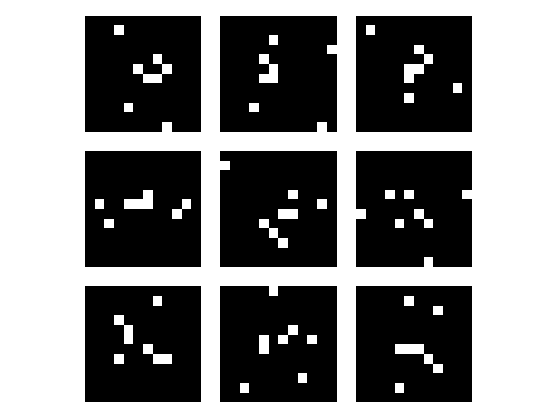

In [17]:
% plot sampling pattern

repetition_plot = 8
f_plot = 1:9;

clim = [0 1];
mask_plot = permute(mask_all(:,:,:,:),[2 3 4 1]); % X, Y, channel, F
montage(mask_plot(:,:,repetition_plot,f_plot), 'MarginWidth',2)
%for f_plot = 1:5
%    subplot(1, 5, f_plot), imshow(permute(mask_all(f_plot,:,:,repetition_plot), [2 3 1]))
%end

Above should be the kx-ky sampling patterns at different times (kf)

slice_plot =  8
repetition_plot =  8
x_plot =  7
y_plot =  7


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



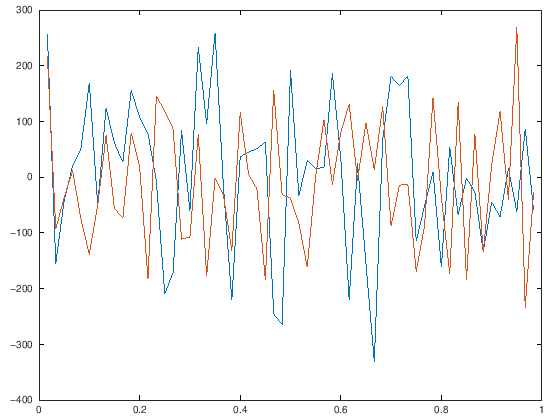

In [20]:
slice_plot = 8
repetition_plot = 8
x_plot = 7
y_plot = 7

spectra_plot_zerofilled = ifftn(data_all(:,:,:,:,repetition_plot))
cplot(spectra_plot_zerofilled(:,x_plot,y_plot,slice_plot))

In [19]:
slice_plot = 8
repetition_plot = 8

spectra_plot_zerofilled = ifftn(data_all(:,:,:,:,repetition_plot))
plot_voxels(permute(abs(spectra_plot_zerofilled(:,:,:,slice_plot),[2 3 1])))

slice_plot =  8
repetition_plot =  8


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



'perl' is not recognized as an internal or external command,
operable program or batch file.
    print_usage at line 74 column 5
error: Invalid call to abs.  Correct usage is:



Additional help for built-in functions and operators is
available in the online version of the manual.  Use the command
'doc <topic>' to search the manual index.

Help and information about Octave is also available on the WWW
at https://www.octave.org and via the help@octave.org
mailing list.


In [ ]:
pyr_ref = abs(squeeze(sum(im_refpeak(:,:,:,1,:),5)));
clim = [0.05 0.8].*max(pyr_ref(:));
subplot(122),montage(permute(pyr_ref,[1 2 4 3]),'DisplayRange',clim,'Size',[3 3])
title('Refpeak Pyruvate')


In [ ]:
%%%%%%%%%%%%%
% L1 Recon
%%%%%%%%%%%%%



In [ ]:
% save dynamic data
tmp_csreorder = read_ddf_image('dummy_ddf/dynth01_phased');
dynamic_cs.ddf = set_ddf_dyn_dim(tmp_csreorder.ddf, 'dynamic_cs', numReps);  
dynamic_cs.ddf.specpoints = 59;
dynamic_cs.img = kspace_all;
dynamic_cs.img = fftshift(fft(dynamic_cs.img,[],1),1);
for fftdim = 2:4,
    dynamic_cs.img = fftshift(ifft(dynamic_cs.img,[],fftdim),fftdim);
end
write_ddf_image_ex([root_dir 'dynamic_cs'],dynamic_cs);